# Problem Definition

Given data about an Enron employee, I want to be able to identify whether that employee is a person of interest (POI) in regard to the Enron scandal. I am working on the hypothesis that this can be done by training a model using data about Enron employees, including known persons of interest.

In [2]:
import sys
import pickle
sys.path.append("./tools/")
from feature_format import featureFormat, targetFeatureSplit
sys.path.append("./final_project/")
from tester import dump_classifier_and_data

### Load the dictionary containing the dataset
with open("./final_project/final_project_dataset_unix.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
my_dataset = data_dict.copy()
data_dict

{'METTS MARK': {'salary': 365788,
  'to_messages': 807,
  'deferral_payments': 'NaN',
  'total_payments': 1061827,
  'loan_advances': 'NaN',
  'bonus': 600000,
  'email_address': 'mark.metts@enron.com',
  'restricted_stock_deferred': 'NaN',
  'deferred_income': 'NaN',
  'total_stock_value': 585062,
  'expenses': 94299,
  'from_poi_to_this_person': 38,
  'exercised_stock_options': 'NaN',
  'from_messages': 29,
  'other': 1740,
  'from_this_person_to_poi': 1,
  'poi': False,
  'long_term_incentive': 'NaN',
  'shared_receipt_with_poi': 702,
  'restricted_stock': 585062,
  'director_fees': 'NaN'},
 'BAXTER JOHN C': {'salary': 267102,
  'to_messages': 'NaN',
  'deferral_payments': 1295738,
  'total_payments': 5634343,
  'loan_advances': 'NaN',
  'bonus': 1200000,
  'email_address': 'NaN',
  'restricted_stock_deferred': 'NaN',
  'deferred_income': -1386055,
  'total_stock_value': 10623258,
  'expenses': 11200,
  'from_poi_to_this_person': 'NaN',
  'exercised_stock_options': 6680544,
  'from_

# Feature Selection

The features in the data fall into three major types, namely financial features, email features and POI labels.

- **financial features**: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)
- **email features**: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)
- **POI label**: [‘poi’] (boolean, represented as integer)

There are a lot of features to look at, so let's start with a PCA of the financial features to get 2 features that we can visualize.

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def scatter_plot(feature, y, labels):
    plt.scatter(feature, y)
    
    
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] # You will need to use more features
data = featureFormat(my_dataset, features_list, sort_keys = True)
is_poi, features = targetFeatureSplit(data)
pca = PCA(n_components=2)
pca.fit(features)
principal = pca.components_[0]
transformed_features = pca.transform(features)
for components in transformed_features:
    plt.scatter(components[0], components[1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
print(pca.explained_variance_ratio_)


<Figure size 640x480 with 1 Axes>

[0.97546174 0.02055623]


There's a a couple of clear outliers. I already know that one due to the totals being included in the data, but I'm not sure about the other one. First, let's get rid of the "total" data.

In [4]:
my_dataset = data_dict.copy()
my_dataset.pop('TOTAL', None)

{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517}

And let's try the PCA again without the total included.

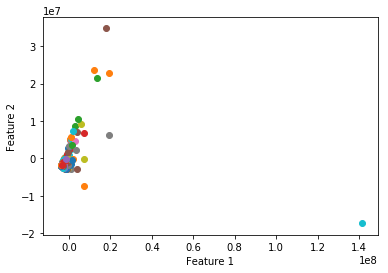

In [5]:
# Get the data using the updated dataset
data = featureFormat(my_dataset, features_list, sort_keys = True)
is_poi, features = targetFeatureSplit(data)

pca.fit(features)
principal = pca.components_[0]
transformed_features = pca.transform(features)
for components in transformed_features:
    plt.scatter(components[0], components[1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

That's better, but I still need to find the other outlier. Let's look at some stats.

In [19]:
import numpy as np

values = {}

for name, employee_data in my_dataset.items():
    for key, value in employee_data.items():
        if value == 'NaN':
            break
        if key in values:
            values[key].append(value)
        else:
            values[key] = [value]

stats = []
for param_name, param_values in values.items():
    if not str(param_values[0]).isdigit():
        break
    stats.append({
        'name': param_name,
        'average': np.mean(param_values),
        'max': np.max(param_values)
    })

stats

[{'name': 'salary', 'average': 284087.5425531915, 'max': 1111258},
 {'name': 'to_messages', 'average': 2425.8805970149256, 'max': 15149},
 {'name': 'deferral_payments', 'average': 1238614.4117647058, 'max': 6426990},
 {'name': 'total_payments', 'average': 9528595.529411765, 'max': 103559793},
 {'name': 'loan_advances', 'average': 41762500.0, 'max': 81525000},
 {'name': 'bonus', 'average': 4500000.0, 'max': 7000000}]

Hmm, I'm not sure this is the right way to go. I don't see an obvious cause for this outlier, so maybe it's better to just continue. After some Googling, it looks like this situation might call for a clustering algorithm.

In [29]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

features_train, features_test, labels_train, labels_test = \
    train_test_split(transformed_features, is_poi, test_size=0.3, random_state=42)
clf = GaussianMixture().fit(features_train, labels_train)
pred = clf.predict(features_test)
acc = accuracy_score(labels_test, pred)
f1 = f1_score(labels_test, pred)

print('Accuracy: ', acc)
print('F1 Score: ', f1)


Accuracy:  0.8613861386138614
F1 Score:  0.0


c:\users\mike\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The decent accuracy and 0 f1 score suggests overfitting, which may be caused by the outlier. Let's see what happens when we remove it.

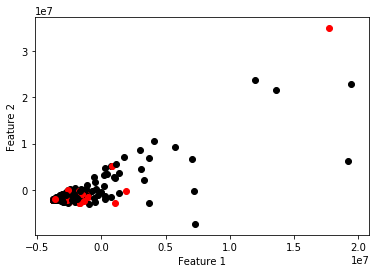

Accuracy:  0.8604651162790697
F1 Score:  0.0


c:\users\mike\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
cleaned_features = transformed_features.copy()
cleaned_labels = is_poi.copy()
outlier_indicies = []

for index, feature in enumerate(transformed_features):
    if feature[0] > 1 * 10 ** 8:
        outlier_indicies.append(index)
        
for index in outlier_indicies:
    cleaned_features = np.delete(cleaned_features, index, 0)
    cleaned_labels = np.delete(cleaned_labels, index, 0)

for index, components in enumerate(cleaned_features):
    color = 'black' if is_poi[index] == 0 else 'red'
    plt.scatter(components[0], components[1], c=color)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

features_train, features_test, labels_train, labels_test = \
    train_test_split(cleaned_features, cleaned_labels, test_size=0.3, random_state=42)
clf = GaussianMixture().fit(features_train, labels_train)
pred = clf.predict(features_test)
acc = accuracy_score(labels_test, pred)
f1 = f1_score(labels_test, pred)

print('Accuracy: ', acc)
print('F1 Score: ', f1)

That didn't help, so it might be time to start removing some features to simplify things a bit.

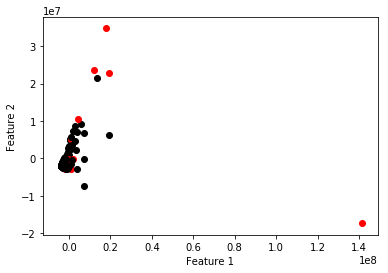

Components:  2
Accuracy:  0.8863636363636364
F1 Score:  0.0
[[39  0]
 [ 5  0]]


c:\users\mike\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\mike\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] # You will need to use more features
# features_list = ['poi', 'salary', 'bonus', 'expenses', 'other', 'long_term_incentive']
data = featureFormat(my_dataset, features_list, sort_keys = True)
is_poi, features = targetFeatureSplit(data)
pca = PCA(n_components=2)
pca.fit(features)
transformed_features = pca.transform(features)

# cleaned_features = transformed_features.copy()
# cleaned_labels = is_poi.copy()

# for index in outlier_indicies:
#     cleaned_features = np.delete(cleaned_features, index, 0)
#     cleaned_labels = np.delete(cleaned_labels, index, 0)
    
for index, components in enumerate(transformed_features):
    color = 'black' if is_poi[index] == 0 else 'red'
    plt.scatter(components[0], components[1], c=color)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

features_train, features_test, labels_train, labels_test = \
    train_test_split(transformed_features, is_poi, test_size=0.3, random_state=42)
clf = SVC().fit(features_train, labels_train)
pred = clf.predict(features_test)
acc = accuracy_score(labels_test, pred)
pre = precision_score(labels_test, pred)
f1 = f1_score(labels_test, pred)
cm = confusion_matrix(labels_test, pred)

print('Components: ', pca.n_components_)
print('Accuracy: ', acc)
print('F1 Score: ', f1)
print(cm)

There is high variance when boiled down to two features, so if I go up to more components, the variances (and hopefully the accuracy) should be even higher. Before we do that, though, let's see what kind of accuracy we can get with these features.

In [23]:
from sklearn.svm import SVC


features_train, features_test, labels_train, labels_test = \
    train_test_split(transformed_features, is_poi, test_size=0.3, random_state=42)
SVC = SVC().fit(features_train, labels_train)
pred = SVC.predict(features_test)
acc = accuracy_score(labels_test, pred)
pre = precision_score(labels_test, pred)
rec = recall_score(labels_test, pred)

print('Accuracy: ', acc)
print('Precision: ', pre)
print('Recall: ', rec)

Accuracy:  0.8863636363636364
Precision:  0.0
Recall:  0.0


c:\users\mike\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The accuracy is decent, but the 0 precision and recall suggest heavy overfitting. Maybe if I get rid of the outliers, that'll improve

## Salary
POIs are likely to make more money since that was a major point of the Enron scandal. This can be seen in the salaries of Kenneth Lay and Jeffery Skilling, \$1,072,321 and \$1,111,258 respectively. Compare this to the hundreds of thousands that most Enron employees make.

In [ ]:
import matplotlib.pyplot as plt

def scatter_plot(feature, y, labels):
    plt.scatter(feature, y)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.show()
    
features_list = ['poi','salary'] # You will need to use more features
data = featureFormat(my_dataset, features_list, sort_keys = True)
is_poi, salaries = targetFeatureSplit(data)
scatter_plot(salaries, is_poi, ('Salary', 'POI'))


There's a pretty major outlier here. Amongst the non-POIs, there's one employee that seems to be getting severely overpaid. There must be a problem here.

In [ ]:
max_salary = max(salaries)[0]
for name, employee in data_dict.items():
    if employee['salary'] == max_salary:
        print('Employee name: ', name)

So we have the total of all salaries also being included. Clearly, that's a problem. Let's completely remove TOTAL from the data since it's probably not going to be of much use.

In [ ]:
my_dataset = data_dict.copy()
my_dataset.pop('TOTAL', None)

Great, now let's check out the salaries again.

In [ ]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
is_poi, salaries = targetFeatureSplit(data)
scatter_plot(salaries, is_poi, ('Salary', 'POI'))

It looks like salaries may not be as obvious a differentiator as I expected. Also, this scatterplot is a little odd plotted with a boolean value. Let's try to generalize this feature a little more.

## Money Earned vs Money Spent
It seems reasonable to assume that there would be a relationship here. I would expect a POI to spend and/or earn higher amounts of money than the average employee. Here are some features that reflect money earned:

- Salary
- Bonus
- Deferred income
- Deferral payments
- Total stock value
- Director Fees
- Long term incentive

Here are some features that reflect money spent:

- Expenses
- Loan advances



In [ ]:
### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


In [ ]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
acc = accuracy_score(labels_test, pred)
print('Accuracy: ', acc)


### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
dump_classifier_and_data(clf, my_dataset, features_list)